In [4]:
import tomotopy as tp
import spacy
from spacy.tokens import DocBin, Doc
Doc.set_extension("ID", default='')
Doc.set_extension("headline", default='')
Doc.set_extension("label", default='')
import pandas as pd 
import os 
from tqdm import tqdm
import numpy as np
import pandas as pd
import regex as re
re.DEFAULT_VERSION = re.VERSION1
import plotly.express as px
from IPython.display import Image
from gensim.models.phrases import Phraser, Phrases
import time
import gc
from bertopic import BERTopic 
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer

## Apply NLP pipeline for tokenization, lemmatization and other features for latter uses

In [38]:
textDf = pd.read_csv('data/le_figaro.csv')
textDf = textDf.fillna('')
textDf

,date,pageNum,paragraphNum,content,headline,label
0,1870-01-01,0,9,Admbûstrateur . AUGUSTE DUNIONT ABOMMBHXins Pa...,,
1,1870-01-01,0,13,m part ri pas demain à l'occasion du jour de l...,Le Figaro,
2,1870-01-01,0,20-21-22-23-24,"Notre éclectisme en roli tique qui, pour être ...",,
3,1870-01-01,0,25-26,"fœil bravement fixé sur le couteau, gravi les ...",,
4,1870-01-01,0,27-28,". Hier matii , lés gens dé Batignolles considé...",,
...,...,...,...,...,...,...
791868,1910-12-31,5,7,Le sujet imaginé par MM. Gheusi et Mé rane aur...,LA SOIRÉE LE MIRACLE A L'OPÉRA,culture
791869,1910-12-31,5,9-10-11-12-13-14-15,M lle Chenal M. Muratore si l'on en juge parla...,A L'OPÉRA Le Miracle,culture
791870,1910-12-31,5,16,à 8 heures pour les représentations de M. Gili...,"Ce-soir : A l'Opéra,",culture
791871,1910-12-31,5,18-19,l'Habitation forcée SUITE derrière le vert ble...,Feuilleton du FIGARO du 31 Décembre,autres


In [42]:
textDf[(textDf.date == '1898-03-28') & (textDf.paragraphNum == '21-22')].values

array([['1898-03-28', 0, '21-22',
        "LES TROUBLES D'ALGER C'est une question que de savoir si vingt années tantôt d'instruotion obligatoire et gratuite ont amélioré l'intelligence et le bon sens du peuple français. C'en est une autre que de savoir si là diffusion et le perfectionnement des moyens de transport et d'information nous permettent d'être mieux renseignés que ne l'étaient nos pères. Connaît-on mieus , les événements , aujourd'hui, qu'on ne les connaissait aux temps lointains où les Gaulois se les transmettaient par leurs cris de colline en colline ? Ainsi, j'avoue que les incidents dont Alger est le théâtre me rendent perplexe et que je n'y comprends rien. Le télégraphe nous apprend : 1 que le Conseil supérieur de l'Algérie prodigue à M: Lépine des marques de satisfaction et de solidarité ; 2 que la Chambre de commerce d'Alger lui exprime sa confiance et sa sympathie; 3 que les membres de la presse algérienne lui ont infligé la privation du titre de président d'honneur 

In [8]:
doc_bin = DocBin(store_user_data=True)

nlp = spacy.load('fr_core_news_lg', exclude=["ner"])
texts = ((row.content, ('_'.join([str(row['date']),str(row['pageNum']),str(row['paragraphNum'])]), 
                        row['headline'], row['label']))
         for _, row in textDf.iterrows())
count = 0
nDocs = len(textDf)
with tqdm(total=len(textDf),mininterval = 5, miniters =1000) as pbar:
    for doc, (ID, headline, label) in nlp.pipe(texts,as_tuples = True, batch_size=2048,n_process=16):
        doc._.ID = ID
        doc._.headline = headline
        doc._.label = label
        doc_bin.add(doc)
        pbar.update(1)
        #split data into several docbin
        if (count%50_000 == 0) or (count == nDocs-1):
            i = int(count/50_000)-4 if (count != nDocs-1) else int(count/50_000) -3
            if count>0:
                doc_bin.to_disk(f"data/spacy/le_figaro{i}.spacy")
                del doc_bin
                gc.collect()
            doc_bin = DocBin(store_user_data=True)
            
        count+=1


 49%|███████████████▎               | 391872/791873 [1:42:38<1:44:46, 63.63it/s]


In [9]:
len(doc_bin)

0

# Pachinko allocation

In [6]:
nlp = spacy.load('fr_core_news_lg', disable=["ner"])

doc_bin = DocBin(store_user_data=True)
for root, dirs, files in os.walk('data/spacy'):
    for name in tqdm(files):
        if name.endswith((".spacy")):
            doc_bin.merge(DocBin(store_user_data=True).from_disk("./data/spacy/"+name))


100%|███████████████████████████████████████████| 12/12 [01:39<00:00,  8.28s/it]
0it [00:00, ?it/s]


In [47]:
def preprocess_text(doc):
    ID = doc._.ID
    headline = doc._.headline
    label = doc._.label
    oovRatio = np.mean([1 if word.is_oov else 0 for word in doc if word.is_alpha])
    lemmas = [word.lemma_.lower() for word in doc 
           if word.is_alpha and (not word.is_stop) and (len(word.lemma_)>2) and (not word.is_oov)] 
    
    return ID, doc.text, lemmas, oovRatio, headline, label

In [55]:
docs = [preprocess_text(doc) for doc in doc_bin.get_docs(nlp.vocab)]
textDf = pd.DataFrame(docs, columns=['ID','content','lemmatized','oovRatio','headline','label'])
textDf = textDf[(textDf.lemmatized.apply(len)>5) &
                (textDf.oovRatio<0.6) &
                (textDf.label=='')]
print(len(textDf))

709265


In [65]:
raw_articles = textDf["lemmatized"].tolist()
bigram = Phrases(raw_articles, min_count=10, threshold=10)
bigram_mod = Phraser(bigram)
raw_articles = list(bigram_mod[raw_articles])
trigram = Phrases(raw_articles, min_count=10, threshold=10)
trigram_mod = Phraser(bigram)
raw_articles = list(trigram_mod[raw_articles])
textDf["nGram"] = raw_articles
textDf["nGram"] = textDf["nGram"].apply(' '.join)
textDf["lemmatized"] = textDf["lemmatized"].apply(' '.join)
textDf.to_csv('data/le_figaro_lemmatized_without_stop.csv',index=False)

In [ ]:
textDf = pd.read_csv('data/le_figaro_lemmatized_without_stop.csv')
raw_articles = textDf.nGram.str.split().to_list()

In [66]:
corpus = tp.utils.Corpus()
for doc in raw_articles:
    if doc:
        corpus.add_doc(doc)

In [ ]:
k1_max = 7
k1_min = 2 
k2_max = 18
k2_min = 8
params = []
scores = []
num_iter = 0
max_iter = 0
for k1 in range(k1_min, k1_max):
    for k2 in range(max(k1,k2_min),k2_max):
        max_iter +=1
        
start = time.time()
for k1 in range(k1_min, k1_max):
    for k2 in range(max(k1,k2_min),k2_max):
        num_iter+=1
        model = tp.PAModel(tw=tp.TermWeight.IDF,min_cf = 10, min_df=5, rm_top=25, k1=k1, k2=k2, corpus=corpus)
        model.burn_in = 20
        model.train(40, workers=24)
        score = tp.coherence.Coherence(model, coherence="c_v").get_score()
        params.append((k1,k2))
        scores.append(score)
        print("Runtime: %.2f seconds" %(time.time() - start), "|| Number of Searches: %s out of  %s" %(num_iter, max_iter), "|| k1: %s & k2: %s || coherence : %.3f" %(k1,k2,score))

In [82]:
for ind,score in enumerate(scores):
    if score>max(scores)*0.95:
        print("k1: %s & k2: %s || coherence : %.3f" %(params[ind][0],params[ind][1],score))


k1: 3 & k2: 9 || coherence : 0.659
k1: 4 & k2: 11 || coherence : 0.685
k1: 4 & k2: 14 || coherence : 0.694
k1: 5 & k2: 15 || coherence : 0.668


In [91]:
k1 = 4
k2 = 14
model = tp.PAModel(tw=tp.TermWeight.IDF,min_cf = 10, min_df=5, rm_top=25, k1=k1, k2=k2, corpus=corpus)
model.burn_in = 20
model.train(100, workers=24)
score = tp.coherence.Coherence(model, coherence="c_v").get_score()
print(score)

0.7261144071817398


In [94]:
for k in range(k2):
    print('Topic #{}'.format(k))
    print("\t", [w for w, p in model.get_topic_words(k)])

Topic #0
	 ['gouvernement', 'angleterre', 'anglais', 'allemagne', 'ministre', 'russie', 'france', 'français', 'allemand', 'empereur']
Topic #1
	 ['officier', 'armée', 'troupe', 'soldat', 'capitaine', 'militaire', 'navire', 'commandant', 'guerre', 'colonel']
Topic #2
	 ['comte', 'mlle', 'comtesse', 'comte_comtesse', 'marquis', 'baron', 'vicomte', 'baronne', 'paul', 'docteur']
Topic #3
	 ['politique', 'france', 'pays', 'république', 'peuple', 'chose', 'esprit', 'gouvernement', 'estper', 'idée']
Topic #4
	 ['monsieur', 'femme', 'aller', 'oeil', 'dire', 'rien', 'main', 'cœur', 'vie', 'jamais']
Topic #5
	 ['rue', 'maison', 'eau', 'vendre', 'prix', 'franc', 'blanc', 'vin', 'noir', 'gramme']
Topic #6
	 ['prix', 'roi', 'course', 'fête', 'prince', 'cheval', 'palais', 'voiture', 'empereur', 'majesté']
Topic #7
	 ['théâtre', 'représentation', 'pièce', 'artiste', 'opéra', 'jouer', 'mlle', 'soir', 'succès', 'rôle']
Topic #8
	 ['franc', 'chambre', 'commission', 'député', 'loi', 'séance', 'million', 

# BERTopic

In [314]:
'''## tokenizer ici meme, découper pour doc entre 256 et 512 bert token, en respectant les phrases et fournir embeddings + token + text
def splitLongDoc(doc):
    if len(doc._.label) != 0:
        return '','', ''
    length = len(doc)
    if length>=800:
        nSegment = int(length/800)+1
        maxLen = length/nSegment
        content = ['']
        for sentence in doc.sents:
            sentLen = len(sentence)
            if (len(content[-1])+sentLen<maxLen) or (len(content[-1]) < 200):
                content[-1] = content[-1] +' '+ sentence.text
            else:
                content.append(sentence.text)
        if len(content[-1])<100:
            content[-2] = content[-2] + ' ' +content[-1]
            content = content[:-1]
            
    else:
        text = doc.text
        content = [text] if len(text)>100 else ''
        
    return doc._.ID, content, doc._.headline'''

class DocSplitor:
    def __init__(self, model = None, tokenizer = None, lim = 382):
        self.model = model.to('cuda:0')
        print(f'Computation on {model.device}')
        self.tokenizer = tokenizer
        self.lim = lim
    
    def mergeList(self, l1,l2):
        return l1+l2
    
    def mergeStr(self, s1,s2):
        return s1+' '+s2
    
    def merge(self, toks1, toks2):
        return {'content':self.mergeStr(toks1['content'],toks2['content']), 
                'tokens':self.mergeList(toks1['tokens'],toks2['tokens']), 
                'lemmas':self.mergeList(toks1['lemmas'],toks2['lemmas']),
                'nTokens':toks1['nTokens']+toks2['nTokens']}
    
    def mergeAll(self, tokenized):
        if len(tokenized)>2:
            return self.merge(tokenized[0],self.mergeAll(tokenized[1:]))
        else:
            return self.merge(*tokenized) if len(tokenized)>1 else tokenized[0]
    
    def checkLim(self, toks1,toks2):
        return ((toks1['nTokens'] + toks2['nTokens']) <= self.lim)
    
    def sentenceProcessing(self, sentence):
        lemmas = [word.lemma_.lower() for word in sentence 
                  if word.is_alpha and (not word.is_stop) and (len(word.lemma_)>2) and (not word.is_oov)] 
        tokens = self.tokenizer.encode(sentence.text)[1:-1]
        return {'content': sentence.text,
                'tokens': tokens,
                'lemmas': lemmas,
                'nTokens': len(tokens)}
    
    
    def groupSentences(self, tokens, length):
        # function to merge list such that it's stay smaller than lim and each block is approximatly the same size 
        if (length>=3):
            if (tokens[0]['nTokens'] <= tokens[2]['nTokens']) and self.checkLim(tokens[0],tokens[1]):
                return ([self.merge(tokens[0],tokens[1])] + 
                        self.groupSentences(tokens[2:],length-2 ))
            
            elif self.checkLim(tokens[1],tokens[2]):
                return ([tokens[0], self.merge(tokens[1],tokens[2])] + 
                        self.groupSentences(tokens[3:],length-3 ))
            
            else: 
                return (tokens[:2] +
                        self.groupSentences(tokens[2:],length-2 ))
            
        elif (length==2):
            if self.checkLim(tokens[0],tokens[1]):
                return [self.merge(tokens[0],tokens[1])] 
            
            else:
                return tokens
            
        else:
            return tokens

    def tokenize(self, doc):

        if len(doc._.label) != 0 or (len(doc)<50):
            return ('','', [], [], [])
        # [1:-1] to remove delimiter
        
        tokenized = [self.sentenceProcessing(sentence) 
                     for sentence in doc.sents]
        if sum([sentence['nTokens'] for sentence in tokenized])>self.lim:
            
            mergeable = True
            while mergeable:
                nBlock = len(tokenized)
                tokenized = self.groupSentences(tokenized,nBlock)
                mergeable = not (nBlock == len(tokenized))
        else: 
            tokenized = [self.mergeAll(tokenized)]

        return (doc._.ID, 
                doc._.headline, 
                [sentence['content'] for sentence in tokenized], 
                [sentence['lemmas'] for sentence in tokenized], 
                [[2]+sentence['tokens']+[3] for sentence in tokenized])
    
    def getAttentionMask(self, attentionLen): 
        return [1]*attentionLen + [0]*(self.lim+2-attentionLen)
    
    def embeds(self, tokens):
        nToks= [len(toks) for toks in tokens]
        attention_mask = torch.IntTensor([getAttentionMask(attentionLen) for attentionLen in nToks]).to('cuda:0')
        input_ids = torch.nn.utils.rnn.pad_sequence(y, batch_first=True).to('cuda:0')
        
        with torch.no_grad():
            output = model(input_ids=input_ids,
                           attention_mask=attention_mask,
                           output_hidden_states=True)
        docEmbs = [docEmb.numpy() for docEmb in output.pooler_output]
        tokEmbs = output.hidden_states[-4:,:,:,:].mean(dim = 0)
        tokEmbs = [tokEmbs[i,:attentionLen,:].numpy() for i, attentionLen in enumerate(nToks)]
        return docEmbs, tokEmbs
        
        
        
    

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dbmdz/electra-base-french-europeana-cased-discriminator")
model =  AutoModel.from_pretrained('dbmdz/bert-base-french-europeana-cased')

In [321]:
BERTDf[BERTDf.tokens.apply(len)>384].content.values

array(["-d'Auvergne, la comtesse de Plouet, la comtesse de Fayve, Mme de Poléon, la comtesse de Saulty, la comtesse des Isnards, la comtesse do Saint-Georges, la comtesse de Mdntreuil, la princesse Zurlo, la duchesse de Lorge, la vicomtesse de Yanssay, la comtesse do :Dreux-Brézé, la comtesse de Montozon, la comtesse de Mon- taigu, la comtesse de Montesquiou, la comtesse de Noinville, la comtesse de Saint-Légier,la duchesse do Bellune, la comtesse de Cossé-Brissac, la comtesse d'Aulan, la comtesse de Tanlay, la baronne de Coix, la baronne de Saint-Amand, la marquise d'Aligre, la marquise de Courcival, la baronne de L'Èspré, la marquise Dodun de Keroman, la comtesse de Bryas, 1a comtesse de Sercey, la comtesse de Ruillé, Mme Duringe, la Comtesse de Yilleneuve, la comtesse de Dam- Êierre, la marquise d'Espeuillcs, la comtesse ouglas, la comtesse de La Boutetière, la comtesse de Breuvery, la baronne La Caze' la comtesse de Vogué, Mme Daguilhon-Pujol, Mme Recopé, la comtesse de Mortemart, 

806


<AxesSubplot:ylabel='Frequency'>

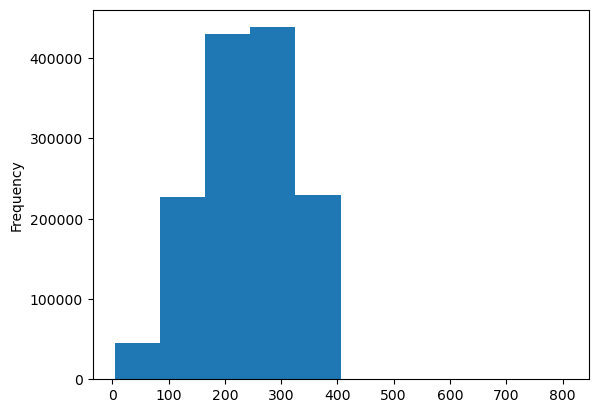

In [319]:
print(BERTDf.tokens.apply(len).max())
BERTDf.tokens.apply(len).plot.hist()

In [318]:
splitor = DocSplitor(model,tokenizer)
            
docs = [splitor.tokenize(doc) for doc in doc_bin.get_docs(nlp.vocab)]
#docs  =[]
#for i in range(20000):
#    docs.append(DocSplitor().tokenize(next(a)))
BERTDf = pd.DataFrame(docs, columns=['ID','headline','content','lemmas','tokens'])
BERTDf = BERTDf.explode(['content','lemmas','tokens'])
BERTDf  =BERTDf[~BERTDf.content.isna()].copy()



0it [05:58, ?it/s].77it/s]


In [156]:
vectorizer_model = CountVectorizer(ngram_range=(1, 3), 
                                   max_df = 0.6,
                                   min_df = 5,
                                   strip_accents = 'unicode')
topic_model = BERTopic(verbose=True,
                       #embedding_model=embedding_model,#'dbmdz/bert-base-french-europeana-cased',
                       nr_topics = 'auto',
                       min_topic_size = 100,
                       vectorizer_model = vectorizer_model)
topics, probs = topic_model.fit_transform(texts,embeddings)


ValueError: Make sure to input embeddings as a numpy array or scipy.sparse.csr.csr_matrix. 

In [181]:
embedding_model.encode(texts[:2000],show_progress_bar=True)

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

array([[-0.4239223 ,  0.02248213, -0.20564407, ..., -0.8670402 ,
        -0.22687754, -0.03607981],
       [-0.24473065, -0.05312259, -0.09280771, ..., -0.5015501 ,
         0.09548544,  0.5582943 ],
       [-0.5172163 , -0.2801716 , -0.24598305, ..., -0.21981826,
         0.14662059, -0.07403921],
       ...,
       [-0.33199543, -0.01667139, -0.2851535 , ..., -0.7983566 ,
        -0.14050919,  0.04579991],
       [-0.37848774,  0.03212813, -0.37159485, ..., -0.7773362 ,
         0.20419456, -0.01591571],
       [-0.46303445,  0.16347334, -0.29598263, ..., -0.7773549 ,
        -0.1193127 ,  0.17085151]], dtype=float32)

In [ ]:
t = time.time()
a = tokenizer(texts[:20])
print(time.time()-t)
print(a)

Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/610 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/222k [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-base-french-europeana-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [196]:
b = model(texts[:1])

In [204]:
[tokenizer(texts[3])]

[{'input_ids': [2, 68, 751, 393, 348, 2609, 336, 79, 11, 2899, 353, 378, 9799, 378, 4835, 514, 3383, 336, 1785, 16, 586, 14600, 366, 4973, 3880, 18, 10568, 347, 11, 1013, 336, 2572, 16, 3880, 68, 15257, 16, 914, 488, 15014, 336, 6258, 366, 3008, 17, 29168, 16, 9593, 27729, 488, 3343, 336, 6954, 365, 12660, 390, 4924, 336, 3939, 5912, 353, 446, 7967, 1202, 130, 13052, 718, 354, 1531, 336, 348, 5386, 16, 630, 399, 79, 11, 584, 71, 11, 1799, 572, 366, 9799, 31772, 18, 6717, 3283, 20038, 15061, 13825, 5412, 542, 2439, 79, 11, 482, 414, 12854, 477, 347, 11, 482, 9575, 1640, 16, 8322, 21523, 4271, 353, 1342, 9587, 1640, 6788, 665, 19969, 718, 2431, 2930, 215, 37, 1177, 17, 405, 8133, 334, 370, 8709, 16, 6494, 16, 16809, 378, 1002, 361, 571, 525, 1118, 347, 11, 677, 361, 13513, 5252, 11, 8705, 506, 2415, 13534, 31, 336, 348, 2754, 336, 11, 10933, 16, 79, 11, 1998, 370, 21310, 7972, 414, 2733, 2382, 422, 671, 361, 1077, 378, 20875, 16, 353, 671, 361, 3096, 23956, 507, 370, 10933, 17, 21310, 79

In [215]:
BERTDf[BERTDf.tokens.apply(len)<20]

,ID,headline,content,tokens
44,1898-03-22_0_7,H. DE VILLEMESSANï? Fondateur ABONNEMENT ' Tro...,On t'abonne dans tous les Bureaux de Poste de ...,"[2, 639, 87, 11, 8467, 422, 671, 361, 11881, 3..."
45,1898-03-22_0_9,"RÉDACTION ADMINISTRATION PUBUOTÏÎ 26, Rue Drou...","ré, i. UAIie 102.46 Rédaction TÉLÉPHONE 102.47...","[2, 437, 16, 76, 18, 57, 1913, 364, 3530, 18, ..."
354,1898-03-26_1_31,,Notre Service' de Librairie so chargé d'envoye...,"[2, 2997, 9323, 11, 336, 14730, 573, 3252, 71,..."
397,1898-03-26_3_95,pOLE j ORD pOLE j jORD,Ouvert de 8 h du matin à midi minuit. Salle en...,"[2, 7760, 336, 28, 75, 378, 974, 130, 1486, 65..."
777,1898-04-01_3_21,"Ce-soir, au Gymnase,","neuvième spectacle d'abonnement, 4 série des v...","[2, 14855, 3953, 71, 11, 9769, 16, 24, 1567, 3..."
...,...,...,...,...
733307,1878-05-11_2_56,"A. DALIFOL, 172, quai Jemmapes, 172 FORGES et ...","Mach à vapeur ver tic' 1 et horizont 1 144, Fa...","[2, 19208, 130, 5283, 1127, 5239, 11, 21, 353,..."
733326,1878-05-11_2_98,"FARINE MORTON ,",Alimentation naturelle des Enfants. Se vend ch...,"[2, 29816, 7697, 370, 14532, 18, 1083, 2733, 1..."
733377,1878-05-11_2_196,,Mme R désire trouver place de dame de compagni...,"[2, 868, 54, 4735, 2061, 1087, 336, 4211, 336,..."
733485,1878-05-12_2_100,"APP grands et petits, chamb",cabin magas boutiq terrains il louer. Pris mod...,"[2, 23585, 213, 4402, 2705, 18214, 9362, 399, ..."


In [207]:
import torch
a = model(torch.tensor([tokenizer.encode(t) for t in texts[:3]]))

ValueError: expected sequence of length 38 at dim 1 (got 325)

In [203]:
a['last_hidden_state'][:,0,:]-a['pooler_output']

tensor([[ 2.4733e-01,  1.6857e-01,  6.5338e-01,  1.7024e-01,  5.9312e-02,
          2.0989e-02, -3.5540e-01,  3.5775e-01,  1.0148e+00,  6.4225e-01,
         -1.5062e-01,  1.0290e+01, -2.5911e-01,  6.7702e-01, -1.9008e-01,
         -6.8659e-02,  1.2729e+00,  1.0137e+00,  8.2785e-01, -4.8681e-01,
          4.3917e-01,  3.0807e-01, -3.1741e-02, -1.6302e+00, -7.0986e-01,
         -1.5057e-01,  3.5652e-01,  4.2652e-01, -1.2928e-01,  6.0701e-01,
          1.6977e+00,  9.8092e-01, -4.3878e-01,  5.2851e-01, -1.0169e+00,
         -1.4644e+00, -1.0988e+00,  4.5423e-01,  7.5249e-01,  1.4139e-01,
          7.5322e-01, -1.3733e+00,  2.2834e-01,  1.5011e+00,  3.0981e-01,
         -6.1100e-01,  8.8547e-01,  6.7765e-01,  1.3227e-01,  4.6886e-01,
          1.1077e+00,  7.7351e-01,  2.5898e-01, -4.8556e-01,  5.0439e-01,
         -9.4194e-01, -3.0323e-01,  2.6878e-01,  4.5885e-01, -1.0652e-01,
         -3.8497e+00,  5.9461e-01,  6.5919e-01, -1.7917e-01,  3.8417e-01,
         -3.3791e-01,  6.4720e-03,  1.

In [198]:
[i for i in a]

['last_hidden_state', 'pooler_output']